# Laboratorio de estimación no-paramétrica
Procesamiento Adaptativo de Señales Aleatorias

© 2019 Tomas A. González Orlando

© 2019 Lucero G. Fernandez

# Ejercicio 1



## Preparativos
Debe guardarse el archivo readligo.py en el directorio correspondiente para poder leer los datos correctamente.

### Clonamos el repositorio de Github

In [63]:
#https://medium.com/@navan0/how-to-push-files-into-github-from-google-colab-379fd0077aa8
!git clone https://github.com/LuFernandez/PASA.git

fatal: destination path 'PASA' already exists and is not an empty directory.


In [64]:
!git init
!git config -- global user.email “togonzalez@itba.edu.ar”
!git config -- global user.name “taomasgonzalez”

Reinitialized existing Git repository in /content/.git/
error: key does not contain a section: global
error: key does not contain a section: global


### Imports necesarios a lo largo del ejercicio

In [0]:
import h5py as h5

import scipy
from scipy import signal as scsig
from scipy.interpolate import interp1d
from scipy import fftpack as scfft

import numpy as np
from numpy.lib import scimath

import matplotlib.pyplot as plt
import readligo as rl
from sklearn.metrics import mean_squared_error
import math

import matplotlib.mlab as mlab

## Lectura de datos

In [0]:
def read_data(path, name):
  strain, time, chan_dict = rl.loaddata(path, name)
  dt = time[1] - time[0]
  times = dt*np.array([i for i in range(len(strain))])
  return (strain, times, chan_dict)

fs = 4096
folder_path = "PASA/TP1. Laboratorio de estimación no-paramétrica/LIGO/"
# leemos los datos de Livingston
strain_l1, times_l1, chan_dict_l1 = read_data(path=folder_path+'L-L1_LOSC_4_V2-1126259446-32.hdf5', name='L1')

# leemos los datos de Hanford
strain_h1, time_h1, chan_dict_h1 = read_data(path=folder_path+'H-H1_LOSC_4_V2-1126259446-32.hdf5', name='H1')


## Visualización de datos

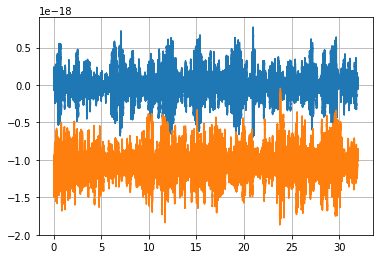

In [67]:
plt.plot(times_l1, strain_h1)
plt.plot(time_h1, strain_l1)
plt.grid()
plt.show()

## a) Estimación del espectro de potencia del ruido mediante el uso de periodogramas

### Implementación del periodograma

In [0]:
def periodogram(fs, data, figure_number, x_lim, title, plot=True):
  # cantidad de muestras
  N = len(data)
  z = scfft.fft(x=data, n=N)
  R = z*np.conj(z)
  freqs = np.fft.fftfreq(N)
  xf = np.linspace(0, fs/2, N//2)    #frecuencias
  if plot:
    plt.loglog(xf, 2/N * np.abs(R[:N//2]))
    plt.loglog(xf, 2/N * np.abs(R[:N//2]))
    plt.xlim(x_lim)
    plt.grid()
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density Rx(f)")
    plt.show()
  
  return (freqs, R)

### Aplicado a Livingston
Hacemos el periodograma para los datos de Livingston en su totalidad, y divididimos en sectores para calcular el error y corroborar estacionariedad.

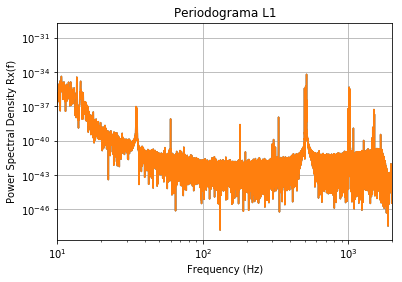

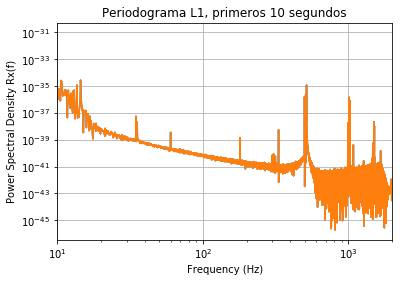

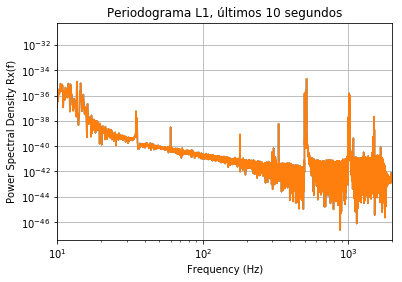

In [69]:
p_f_l1_tot, p_Pxx_l1_tot = periodogram(fs=fs, data=strain_l1, figure_number=1, x_lim=(10, 2000), title="Periodograma L1")
p_f_l1_first, p_Pxx_l1_first = periodogram(fs=fs, data=strain_l1[:len(strain_l1)//3], figure_number=1, x_lim=(10, 2000), title="Periodograma L1, primeros 10 segundos")
p_f_l1_last, p_Pxx_l1_last = periodogram(fs=fs, data=strain_l1[int(len(strain_l1)*2/3)+1:], figure_number=1, x_lim=(10, 2000), title="Periodograma L1, últimos 10 segundos")


In [70]:
rmse = np.square(np.abs(np.subtract(Pxx_l1a,Pxx_l1b[1:]))).mean() 
print("La raíz del error cuadrático medio o RMSE (Rooted Mean Square Error) es:", rmse,
      "\npor lo que se puede decir que el periodograma de un tramo de los datos es representativo de todo el ensamble.")

ValueError: ignored

### Aplicado a Hanford
Hacemos el periodograma para los datos de Hanford en su totalidad, y divididimos en secotres para calcular el error y corroborar estacionariedad.

In [0]:
p_f_h1_tot, Pxx_h1_tot = periodogram(fs=fs, data=strain_h1, figure_number=1, x_lim=(10, 2000), title="Periodograma H1")
p_f_h1_first, p_Pxx_h1_first = periodogram(fs=fs, data=strain_h1[:len(strain_h1)//3], figure_number=2, x_lim=(10, 2000), title="Periodograma H1, primeros 10 segundos")
p_f_h1_last, p_Pxx_h1_last = periodogram(fs=fs, data=strain_h1[int(len(strain_l1)*2/3):], figure_number=3, x_lim=(10, 2000), title="Periodograma H1, últimos 10 segundos")

In [0]:
rmse = np.square(np.abs(np.subtract(Pxx_h1a,Pxx_h1b[1:]))).mean() 
print("La raíz del error cuadrático medio o RMSE (Rooted Mean Square Error) es:", rmse,
      "\npor lo que se puede decir que el periodograma de un tramo de los datos es representativo de todo el ensamble.")

## b) Estimación del espectro de potencia del ruido mediante el uso del método de Blackman-Tukey

### Implementación del método de Blackman-Tukey

Definimos cómo crear la ventana necesaria:

In [0]:
def create_b_tukey_window(N, M, L):
  delta_w = 2*np.pi/N* (2*M+1) 
  l = np.arange(1,L+1)
  window = np.sin(delta_w*l / 2)  / (np.pi * l)                 
  window = np.append( np.flip(window), np.append([delta_w/2/np.pi] , window) )
  return window

Definimos cómo estimar la autocorrelación de una señal ruidosa:

In [0]:
def autocorrelation_estimation(data, L, N):
  # Formamos el vector r_x con todos l de 0 a L 
  if data.dtype is not complex:
    data = data.astype(complex)
    
  # complex conjugate of the first argument is used for the calculation of the dot product.
  r_x = np.array([np.vdot(data[0:N-l]/N, data[l:N]) for l in range(0, L+1)])
  # terminamos de completar r_x con los valores de -L a -1:
  r_x = np.append( np.flip( np.conj(r_x[1:]) ) , r_x )
  return r_x

Finalmente, implementamos el método:

In [0]:
#frac_N_l = N/l
def blackman_tukey(fs, data, figure_number, M, x_lim, title='', N=4096, frac_N_l=5, plot=True):
  # cantidad de muestras N
  # Se recomienda N mayor a 50, y |l| ≤ N/4 (Box & Jenkins, 1976). 
  L = N//frac_N_l
  if N <= 50:
    print('Se recomienda elegir una cantidad de muestras mayor a 50! (Box & Jenkins, 1976)')
  if L > N//4:
    print('Se recomienda elegir |l|<=N/4! (Box & Jenkins, 1976)')
    
  r_xw = autocorrelation_estimation(data=data, L=L, N=N) * create_b_tukey_window(N, M, L)

  z = abs(scfft.fft(x=r_xw, n=len(r_xw)))
  
  freqs = np.fft.fftfreq(n=len(r_xw), d=1/fs)
  if plot: 
    plt.loglog(freqs, z)
    plt.loglog(freqs, z)
    plt.xlim(x_lim)
    plt.grid()
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density Rx(f)")
    plt.show()
  return (freqs, z)

### Aplicado a los datos de Livingston

In [0]:
b_f_l1_tot, b_Pxx_l1_tot = blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1',M=20, N=4096*20, frac_N_l=10)
b_f_l1_first, b_Pxx_l1_first = blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1',M=20, N=4096*20, frac_N_l=10)
b_f_l1_last, b_Pxx_l1_last = blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=20, N=4096*20, frac_N_l=10)

### Aplicado a los datos de Hanford

In [0]:
b_f_h1_tot, b_Pxx_h1_tot = blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=200, frac_N_l=5)
b_f_h1_first, b_Pxx_h1_first = blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=20, frac_N_l=5)
b_f_h1_last, b_Pxx_h1_last = blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=20, frac_N_l=5)

## c) Estimación del espectro de potencia del ruido mediante el uso del método de Welch-Barlett

### Implementación del método de Welch-Barlett

En la implementación de Welch Barlett, se utiliza una ventana de tipo Hanning para reducir el bias. Probándose con una ventana cuadrada, se observó un bias notable (las frecuencias altas se veían atenuadas con respecto al espectro correcto).

In [0]:
#Inspirado en https://stackoverflow.com/questions/46882312/python-implementation-of-bartlett-periodogram

#nperseg : L
def welch_barlett(data, fs,  D=0, nperseg=512, nfft=512, title='',x_lim=(10,2000), plot=True):
    if nfft % 2:
      numFreqs = (nfft + 1)//2
    else:
      numFreqs = nfft//2 + 1
      
    x = mlab.stride_windows(data, nfft, 0, axis=0)
    window = np.ones(nfft, x.dtype)
    window = np.hanning(len(np.ones(nfft, x.dtype)))*np.ones(nfft, x.dtype)
    x = x * window.reshape((-1, 1))
    x = np.fft.fft(x, n=nfft, axis=0)[:numFreqs, :]
    freqs = np.fft.fftfreq(nfft, 1/fs)[:numFreqs]

    x = np.conj(x) * x
    
    x /= fs
    x /= (np.abs(window)**2).sum()
    x = np.transpose(x).sum(axis=0)/len(x[1])
    if plot: 
      plt.loglog(freqs, x)
      plt.xlim(x_lim)
      plt.grid()
      plt.title(title)
      plt.xlabel("Frequency (Hz)")
      plt.ylabel("Power Spectral Density Rx(f)")
      plt.show()
    return freqs, x 


### Aplicado a los datos de Livingston

Metodo nuevo

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


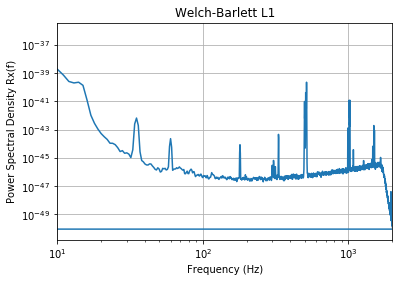

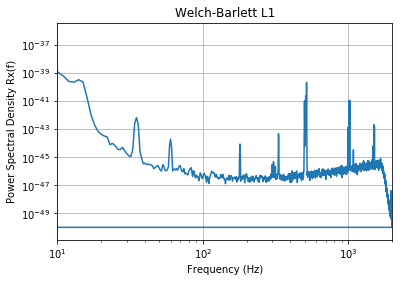

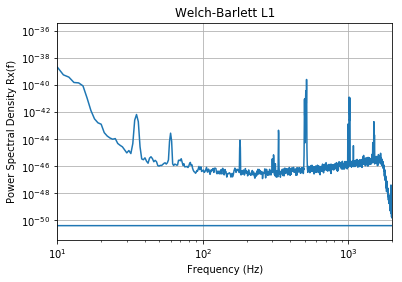

In [250]:
nperseg = 4096
nfft = nperseg
w_f_l1_tot, w_Pxx_l1_tot = welch_barlett(data=strain_l1, fs=fs, nperseg=nperseg, nfft=nfft, title='Welch-Barlett L1',x_lim=(10,2000), plot=True)
w_f_l1_first, w_Pxx_l1_first = welch_barlett(data=strain_l1[:int(len(strain_l1)/3)], fs=fs, nperseg=nperseg, nfft=nfft, title='Welch-Barlett L1',x_lim=(10,2000), plot=True)
w_f_l1_last, w_Pxx_l1_last = welch_barlett(data=strain_l1[int(len(strain_l1)*2/3):], fs=fs, nperseg=nperseg, nfft=nfft, title='Welch-Barlett L1',x_lim=(10,2000), plot=True)


### Aplicado a los datos de Hanford

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


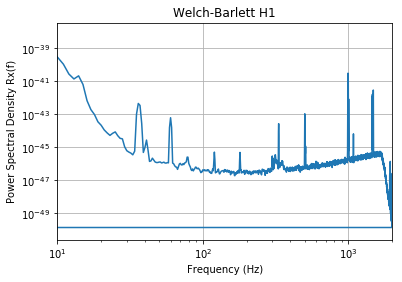

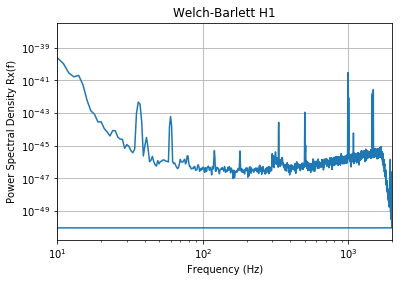

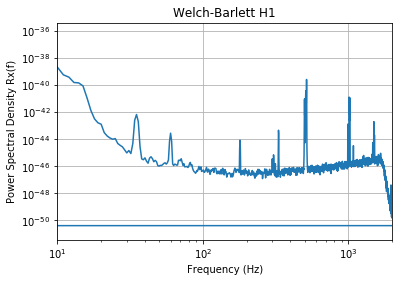

In [252]:
w_f_h1_tot, w_Pxx_h1_tot = welch_barlett(data=strain_h1, fs=fs, nperseg=nperseg, nfft=nfft, title='Welch-Barlett H1',x_lim=(10,2000), plot=True)
w_f_h1_first, w_Pxx_h1_first = welch_barlett(data=strain_h1[:int(len(strain_h1)/3)], fs=fs, nperseg=nperseg, nfft=nfft, title='Welch-Barlett H1',x_lim=(10,2000), plot=True)
w_f_h1_last, w_Pxx_h1_last = welch_barlett(data=strain_l1[int(len(strain_h1)*2/3):], fs=fs, nperseg=nperseg, nfft=nfft, title='Welch-Barlett H1',x_lim=(10,2000), plot=True)

## d) Estimación del espectro de potencia del ruido mediante el uso del enfoque multitaper con funciones DPSS

### Implementación del método multitaper con funciones DPSS

In [0]:
# para la matemática:
# https://ccrma.stanford.edu/~jos/sasp/Slepian_DPSS_Window.html
# para las ventanas:
# https://scipy.github.io/devdocs/generated/scipy.signal.windows.dpss.html
def multitaper_dpss(data, fs, windows, x_lim=(10,2000), title='', plot=True):
  # tomo a x_lim[1] como el bandwith!!!
  R_i = abs( np.fft.fft( a=np.multiply(data,windows) ) ) ** 2 / len(data)
  freqs = np.fft.fftfreq( n=len(data), d=1/fs )
  R = np.sum(R_i, axis=0) / len(windows)
  if plot: 
    plt.loglog(freqs, 2/len(data) * R)
    plt.loglog(freqs, 2/len(data)  * R)
    plt.xlim(x_lim)
    plt.grid()
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density Rx(f)")
    plt.show()
  return freqs, R

### Aplicado a los datos de Livingston

Preparamos las ventanas slepianas con las que vamos a trabajar sobre los datos.

In [0]:
# sym bool, optional
# When True (default), generates a symmetric window, for use in filter design. When False, generates a periodic window, for use in spectral analysis.
bw = 2000
sequences = scsig.windows.dpss(M=len(strain_l1), NW=bw/(2*fs), Kmax=100, sym=False)

In [0]:
d_f_l1_tot, f_Pxx_l1_tot = multitaper_dpss(data=strain_l1, fs=fs, windows=sequences, x_lim=(10,2000), title='Multitaper L1', plot=True)
d_f_l1_first, f_Pxx_l1_first = multitaper_dpss(data=strain_l1, fs=fs, windows=sequences, x_lim=(10,2000), title='Multitaper L1, primeros 10 segundos', plot=True)
d_f_l1_last, f_Pxx_l1_last = multitaper_dpss(data=strain_l1, fs=fs, windows=sequences, x_lim=(10,2000), title='Multitaper L1, últimos 10 segundos', plot=True)

### Aplicado a los datos de Hanford

Preparamos las ventanas slepianas con las que vamos a trabajar sobre los datos.

In [0]:
bw = 2000 
# sym bool, optional
# When True (default), generates a symmetric window, for use in filter design. When False, generates a periodic window, for use in spectral analysis.
sequences = scsig.windows.dpss(M=len(strain_h1), NW=bw/(2*fs), Kmax=100, sym=False)

In [0]:
d_f_h1_tot, f_Pxx_h1_tot = multitaper_dpss(data=strain_h1, fs=fs, windows=sequences, x_lim=(10,2000), title='Multitaper H1', plot=True)
d_f_h1_tot, f_Pxx_h1_tot = multitaper_dpss(data=strain_h1, fs=fs, windows=sequences, x_lim=(10,2000), title='Multitaper H1, primeros 10 segundos', plot=True)
d_f_h1_tot, f_Pxx_h1_tot = multitaper_dpss(data=strain_h1, fs=fs, windows=sequences, x_lim=(10,2000), title='Multitaper H1, últimos 10 segundos', plot=True)

#Ejercicio 2

## Inversa del espectro de potencia del ruido


### Implementación el filtro inversor

In [0]:
def inverse_spectogram(data):
  return 1/scimath.sqrt(data)

Utilización del filtro inversor en la señal

In [0]:
f_l1, Pxx_l1 = periodogram(fs=fs, data=strain_l1, figure_number=1, x_lim=(10, 2000), title="Periodograma L1")
f, R = welch_barlett(data=strain_l1, fs=fs,  D=0, nperseg=len(f_l1), nfft=len(f_l1), title='Welch-Barlett L1',x_lim=(10,2000), plot=True)
inv_R = inverse_spectogram(R)

plt.loglog(f, 2/len(f) * inv_R)
plt.xlim((10,2000))
plt.grid()
plt.title('Inverse')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density Rx(f)")
plt.show()

invertido = np.multiply(abs(Pxx_l1), abs(inv_R)**2)

plt.loglog(f, 2/len(f) * invertido)
plt.xlim((10,2000))
plt.grid()
plt.title('Inverse_mult')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density Rx(f)")
plt.show()

## Visualización en frecuencia del resultado

### Livingston

### Hanford

## Visualización en tiempo del resultado

### Livingston

### Hanford

## Aplicamos filtro pasabandas en la zona de interés

In [0]:
# creamos un filtro con las frecuencias recomendadas por LIGO
bb, ab = scsig.butter(4, [20.*2./fs, 300.*2./fs], btype='band')


### Livingston

In [0]:
strain_l1_white_bp = filtfilt(bb, ab, strain_l1_white)

### Hanford

In [0]:
strain_h1_white_bp = filtfilt(bb, ab, strain_h1_white)

## Buscamos el time shift correspondiente

Debido a que estamos trabajando con ondas cuyas velocidades corresponden a velocidades relativistas, sabemos que los eventos no sucederán simultáneamente en cada sistema. 
Buscamos encontrar entonces el corrimiento en tiempo que deberemos realizar en los datos de uno de los dos sistemas para poder verificar la correspondencia entre eventos.
Para solucionar este problema, hallamos las correlaciones cruzadas entre los datos de Hanford y los de Livingston. 
Pondremos una cota para los tiempos de shifting que podremos encontrar para así reducir el tiempo de cálculo.
Dado que la distancia entre Hanford y Livingston es de  3030.13 km, (https://astronomy.stackexchange.com/questions/13704/gravitational-wave-detection-time-difference-between-ligo-livingston-and-ligo-ha) y la velocidad de la luz es de 299792458 (km/s), entonces el máximo shifting en tiempo que se podrá tener entre las dos señales es de 10(ms). 


### Implementación de la autocorrelación y obtención del time shift

In [0]:
# https://stackoverflow.com/a/4688875
def get_time_shift(data1, data2):
  af = scipy.fft(data1)
  bf = scipy.fft(data2)
  c = scipy.ifft(af * scipy.conj(bf))

  time_shift = argmax(abs(c))
  return time_shift

time_shift = get_time_shift(strain_l1, strain_h1)
print('Time shift: ' + str(time_shift))